In [10]:
%matplotlib notebook
import matplotlib as mpl
mpl.use('pdf')
# mpl.rcParams.update({'font.size': 26})

import os
import pandas as pd
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from itertools import product, takewhile
from collections import defaultdict
from plot_utils import richify_line_style

/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [28]:
from cycler import cycler
plt.rc('axes',
       prop_cycle=(
           cycler('color', ['y', 'g', 'r', 'g', 'g', 'b']) +
           cycler('linestyle', ['-', '-.', ':', '-.', '--', '-']) +
           cycler('marker', ['s', 'o', '*', '*', 'o', '*'])
       ))

In [34]:
if True:
    datasets = ['p2p-gnutella08', 'arxiv-hep-th', 'enron-email']
    models = ['si']
else:
    datasets = ['p2p-gnutella08']
    models = ['si', 'ic', 'sp']
methods = ["greedy", "tbfs", "mst"]  
qs = np.linspace(0.005, 0.1, 20)
qs_str = list(map(str, qs))

column_names = ['mmc', 'prec', 'rec', 'obj']

In [35]:
dirname_template = "outputs/paper_experiment/{dataset}/{model}/{method}/qs/{q}.pkl"

In [36]:
result = {}
for dataset, model in product(datasets, models):
    key = (dataset, model)
    result[key] = {}
    for method in methods:
        result[key][method] = []
        for q in qs_str:
            path = dirname_template.format(dataset=dataset, model=model, method=method, q=q)
            try:
                result[key][method].append(pd.read_pickle(path))
            except FileNotFoundError:                
                dummy = defaultdict(lambda :defaultdict(lambda: None))
                result[key][method].append(dummy)

<IPython.core.display.Javascript object>


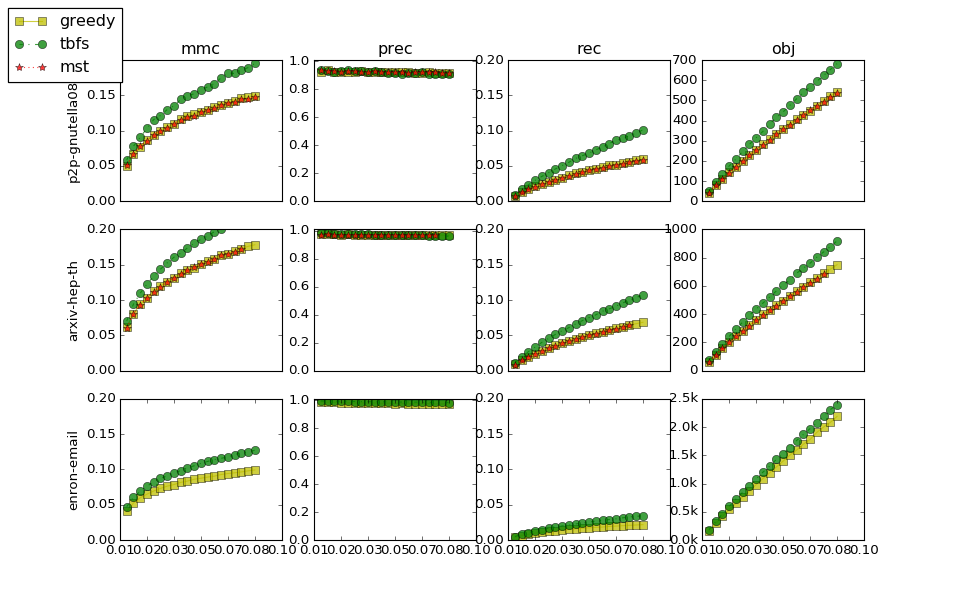

In [38]:
nrow = (len(datasets) if len(datasets) > 1 else len(models))
per_size, ncol = 3, len(column_names)
fig = plt.figure(figsize=(ncol * per_size,
                 (nrow-0.5) * per_size))
for i, (dataset, model) in enumerate(product(datasets, models)):
    key = (dataset, model)
    # one plot
    for j, column in enumerate(column_names):
        if i == 0:
            lines = []
        idx = i * ncol + j + 1
        ax = fig.add_subplot(nrow, ncol, idx)
        for method in methods:
            # one legend
            ys = [df[column]['mean'] for df in result[key][method]]
            lst = list(zip(*takewhile(lambda tpl: tpl[1] is not None, zip(qs, ys))))
            if lst:
                correct_qs, correct_ys = lst
                l, = ax.plot(correct_qs, correct_ys, markersize=7.5, alpha=0.75)
                if i == 0:
                    lines.append(l)
            else:
                continue
        if i == 0:
            ax.set_title(column)
        if j == 0:
            if len(datasets) > 1:
                ax.set_ylabel(dataset)
            else:
                ax.set_ylabel(model.upper())
        if i == nrow - 1:
            ticklabels = list(map(lambda s: '{:.2f}'.format(s), qs[::3]))            
            ax.set_xticklabels(ticklabels)
        else:
            ax.set_xticks([])
        ylim = None
        if column == "prec":
            ylim = (0, 1.01)
        if column == "rec":
            ylim = (0, 0.2)
        if column == 'mmc':
            ylim = (0, 0.2)
        if ylim is not None:
            ax.set_ylim(*ylim)
        if column in {'mmc', 'rec'}:
            yticks = ax.get_yticks()
            ax.set_yticklabels(list(map(lambda s: "{:.2f}".format(s), yticks)))
        if column == 'obj':
            yticks = ax.get_yticks()
            if yticks.max() > 1000:
                ax.set_yticklabels(list(map(lambda v: "{:.1f}k".format(v / 1000), yticks)))
    fig.legend(lines, methods, loc='upper left')

if len(datasets) > 1:
    fig.savefig('figs/paper_experiment/measure_by_datasets.pdf')
else:
    fig.savefig('figs/paper_experiment/measure_by_models.pdf')